# SAX


## Imports

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from aeon.transformations.collection.dictionary_based import SAX
from aeon.datasets import load_unit_test
from matplotlib import colormaps
from sklearn.preprocessing import StandardScaler

# Test
# Test 2

## Helper Methods

In [9]:
def getEntity(number, name):
    correctName = name + "s" if number > 1 else name
    return f"{number} {correctName}"

# Print general information of dataset
def printGeneralInfo(sax, dataset, dataset_scaled, dataset_sax, increment, time_steps, n_segments):
    
    #print("sax.get_fitted_params")
    #print(sax.get_fitted_params())

    print(f"dataset.shape: {dataset.shape}")
    samples = getEntity(dataset.shape[0], 'sample')
    dimensions = getEntity(dataset.shape[1], 'dimension')
    time_steps = getEntity(dataset.shape[2], 'time step')
     
    print(f"{samples}, {dimensions}, {time_steps}\n")
    
    print(f"dataset_scaled.shape: {dataset_scaled.shape}")
    print(f"dataset_sax.shape: {dataset_sax.shape}")
    
    segments = getEntity(n_segments, "segment")
    increments = getEntity(increment, "time step")
    print(f"\n{segments}")
    print(f"{increments} per segment")
    
    
# Prints a grid of samples from a given dataset
# rows and columns have to be greater than 1
def drawGrid(sax, dataset, dataset_scaled, dataset_sax, n_segments, rows=2, columns=3):

    # Define segments as pairs of (start, end) indices with constant values
    # segments = [(5, 20), (20, 30), (30, 50), (50, 70), (70, 80), (80, 95)]  # Segment boundaries
    # segment_values = [4, 6, 5, 7, 3, 8]  # Horizontal segment values for the plot (y-values)

    time_steps = dataset.shape[2]
    assert time_steps % n_segments == 0, "Number of time frames has to be evenly dividable by the number of segments."

    
    increment = int(time_steps / n_segments)
    
    printGeneralInfo(sax, dataset, dataset_scaled, dataset_sax, increment, time_steps, n_segments)
    
    # Define a Colormap
    get_color = colormaps['tab10']

    # Define an alphabet with corresponding labels
    alphabet = ['a', 'b', 'c', 'd']  # Alphabet labels
    #segment_labels = [0,1,2,3,0,1]  # Alphabetic labels for each segment


    fig, grid = plt.subplots(rows, columns, figsize=(columns * 4, rows * 4))
    for i, row in enumerate(grid):
        for j, ax in enumerate(row):
            sample_index = i * columns + j

            sample = dataset[sample_index][0]
            sample_sax = dataset_sax[sample_index][0]

            # Plot original time series
            ax.plot(sample)
            ax.set_title(f"Sample {sample_index+1}")

            start = 0
            end = increment
            
            for s in range(n_segments):
                s_value = np.mean(sample[start : end])
                
                # Horizontal segment values for the plot (y-values)
                color = get_color(sample_sax[s])
                ax.hlines(y=s_value, xmin=start, xmax=end-1, color=color, linewidth=3)  # Horizontal line
                
                # Update indices
                start = end
                end += increment

    plt.tight_layout()
    plt.show()


# Prepare dataset and use SAX to ...
def applySAX(dataset, n_segments=8, alphabet_size=4, rows=2, columns=3):

    # Initialize SAX
    sax = SAX(n_segments, alphabet_size)

    # Make sure that number of time steps is dividable by n_segments
    remainder = dataset.shape[2] % n_segments
    if(remainder != 0):
        fillers = n_segments - remainder
        meansToFill = np.repeat(np.mean(dataset, axis=2), fillers, axis=1)
        dataset = np.append(dataset[:,0,:], meansToFill, axis = 1) 
        # append function automatically removes all 1s in array shape, add it manually:  
        dataset = np.expand_dims(dataset, 1)
        print(f"Added {getEntity(fillers, 'mean')}")


    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler on the training data (learn the mean and standard deviation)
    # Transform both the training and test data
    # Transposition on input and output added, as StandardScaler operates column-wise (e.g. calculates mean of first column)
    dataset_scaled = scaler.fit_transform(dataset[:, 0, :].T).T

    # Fit and transform the data
    dataset_sax = sax.fit_transform(dataset_scaled)

    # Draw the grid
    drawGrid(sax, dataset, dataset_scaled, dataset_sax, n_segments, rows=rows, columns=columns)

## SAX Class

In [11]:
class SAXTransformer:
    def __init__(self, n_segments=8, alphabet_size=4):
        self.n_segments = n_segments
        self.alphabet_size = alphabet_size
        self.sax = SAX(self.n_segments, self.alphabet_size)

    def transform(self, dataset):
        # Make sure that number of time steps is dividable by n_segments
        remainder = dataset.shape[2] % self.n_segments
        if(remainder != 0):
            fillers = self.n_segments - remainder
            meansToFill = np.repeat(np.mean(dataset, axis=2), fillers, axis=1)
            dataset = np.append(dataset[:,0,:], meansToFill, axis = 1) 
            # append function automatically removes all 1s in array shape, add it manually:  
            dataset = np.expand_dims(dataset, 1)
            print(f"Added {self.getEntity(fillers, 'mean')}")
            
        # Create a StandardScaler object
        scaler = StandardScaler()

        # Fit the scaler on the training data (learn the mean and standard deviation)
        # Transform both the training and test data
        # Transposition on input and output added, as StandardScaler operates column-wise (e.g. calculates mean of first column)
        dataset_scaled = scaler.fit_transform(dataset[:, 0, :].T).T

        # Fit and transform the data
        dataset_sax = self.sax.fit_transform(dataset_scaled)
        
        return dataset, dataset_sax, dataset_scaled

    @staticmethod
    def getEntity(number, name):
        correctName = name + "s" if number > 1 else name
        return f"{number} {correctName}"

    # Print general information of dataset
    def printGeneralInfo(self, dataset, dataset_scaled, dataset_sax, increment, time_steps):

        #print("self.sax.get_fitted_params")
        #print(self.sax.get_fitted_params())

        print(f"dataset.shape: {dataset.shape}")
        samples = self.getEntity(dataset.shape[0], 'sample')
        dimensions = self.getEntity(dataset.shape[1], 'dimension')
        time_steps = self.getEntity(dataset.shape[2], 'time step')

        print(f"{samples}, {dimensions}, {time_steps}\n")

        print(f"dataset_scaled.shape: {dataset_scaled.shape}")
        print(f"dataset_sax.shape: {dataset_sax.shape}")

        segments = self.getEntity(self.n_segments, "segment")
        increments = self.getEntity(increment, "time step")
        print(f"\n{segments}")
        print(f"{increments} per segment")


    # Prints a grid of samples from a given dataset
    # rows and columns have to be greater than 1
    def drawGrid(self, dataset, dataset_scaled, dataset_sax, rows=2, columns=3):

        # Define segments as pairs of (start, end) indices with constant values
        # segments = [(5, 20), (20, 30), (30, 50), (50, 70), (70, 80), (80, 95)]  # Segment boundaries
        # segment_values = [4, 6, 5, 7, 3, 8]  # Horizontal segment values for the plot (y-values)

        time_steps = dataset.shape[2]
        assert time_steps % self.n_segments == 0, "Number of time frames has to be evenly dividable by the number of segments."


        increment = int(time_steps / self.n_segments)

        self.printGeneralInfo(dataset, dataset_scaled, dataset_sax, increment, time_steps)

        # Define a Colormap
        get_color = colormaps['tab10']

        # Define an alphabet with corresponding labels
        alphabet = ['a', 'b', 'c', 'd']  # Alphabet labels
        #segment_labels = [0,1,2,3,0,1]  # Alphabetic labels for each segment


        fig, grid = plt.subplots(rows, columns, figsize=(columns * 4, rows * 4))
        for i, row in enumerate(grid):
            for j, ax in enumerate(row):
                sample_index = i * columns + j
                sample = dataset[sample_index][0]
                sample_sax = dataset_sax[sample_index][0]

                # Plot original time series
                ax.plot(sample)
                ax.set_title(f"Sample {sample_index + 1}")

                start = 0
                end = increment

                for s in range(self.n_segments):
                    s_value = np.mean(sample[start : end])

                    # Horizontal segment values for the plot (y-values)
                    color = get_color(sample_sax[s])
                    ax.hlines(y=s_value, xmin=start, xmax=end-1, color=color, linewidth=3)  # Horizontal line

                    # Update indices
                    start = end
                    end += increment

        plt.tight_layout()
        plt.show()
        

# Datasets

## Test Dataset

Added 1 mean
dataset.shape: (8, 1, 6)
8 samples, 1 dimension, 6 time steps

dataset_scaled.shape: (8, 6)
dataset_sax.shape: (8, 1, 3)

3 segments
2 time steps per segment


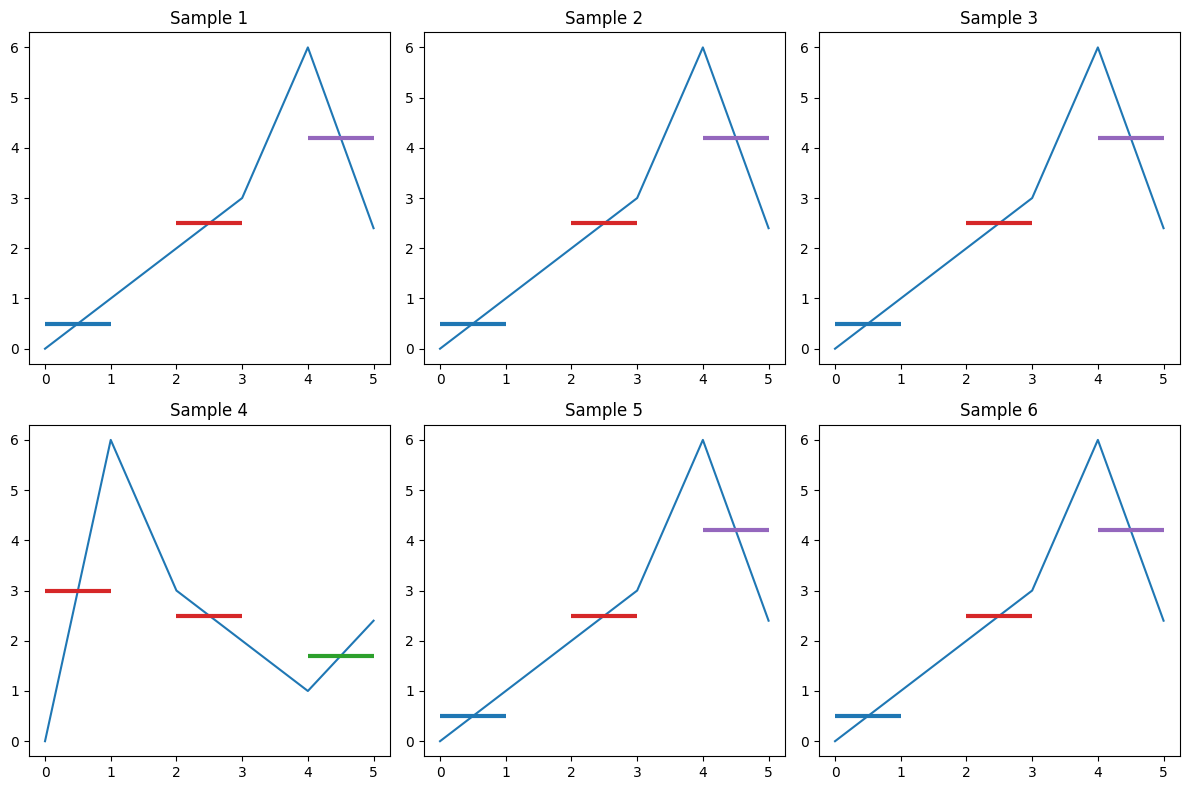

In [12]:
dataset = np.array([[[0, 1, 2, 3, 6]],
                    [[0, 1, 2, 3, 6]],
                    [[0, 1, 2, 3, 6]],
                    [[0, 6, 3, 2, 1]],
                    [[0, 1, 2, 3, 6]],
                    [[0, 1, 2, 3, 6]],
                    [[0, 1, 2, 3, 6]],
                    [[0, 6, 3, 2, 1]],])

applySAX(dataset, n_segments=3, alphabet_size=6)

Added 1 mean
dataset.shape: (8, 1, 6)
8 samples, 1 dimension, 6 time steps

dataset_scaled.shape: (8, 6)
dataset_sax.shape: (8, 1, 3)

3 segments
2 time steps per segment


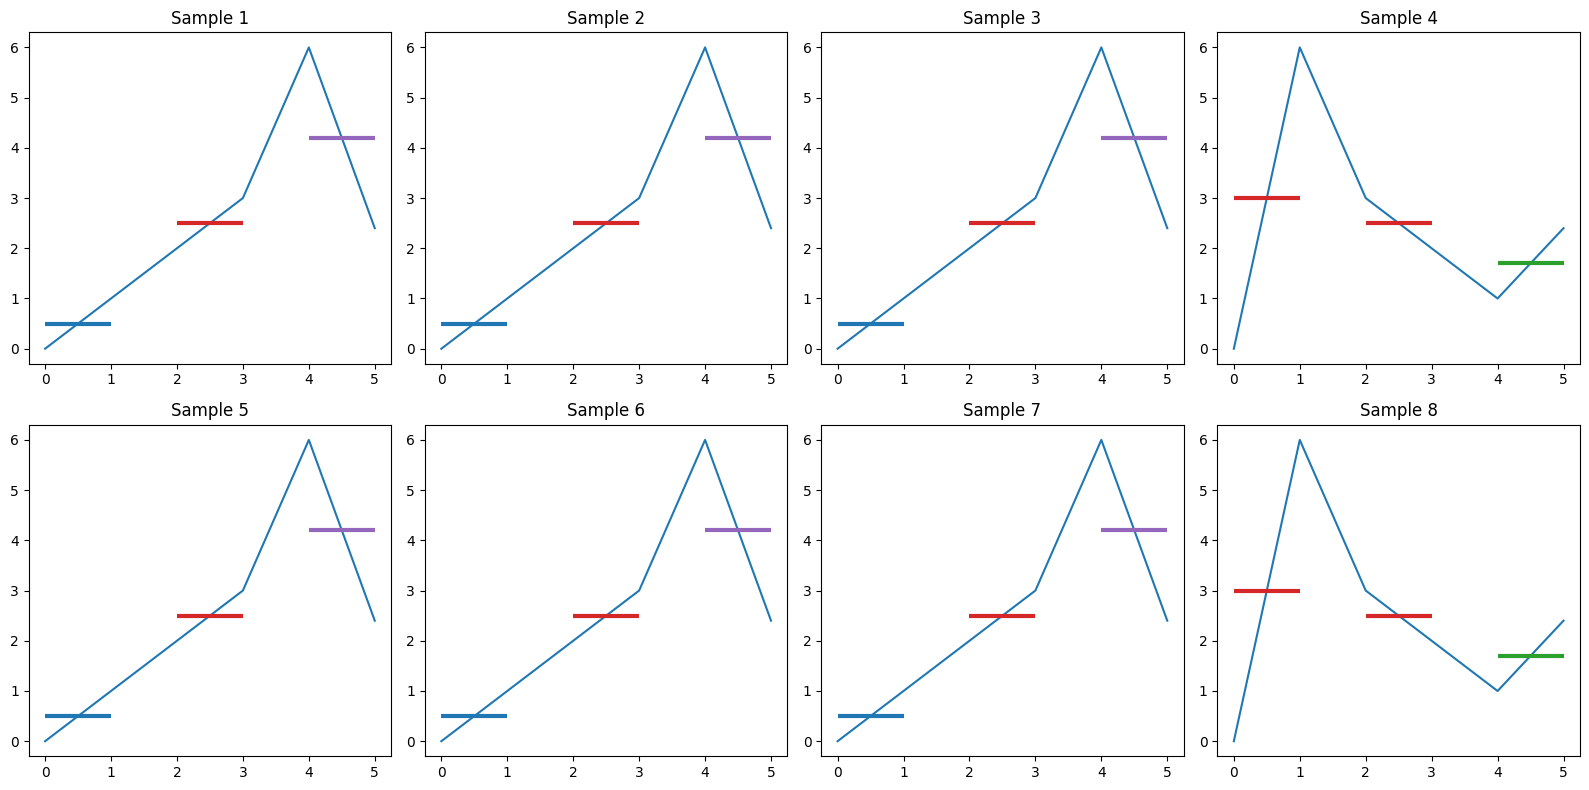

In [8]:
dataset = np.array([[[0, 1, 2, 3, 6]],
                    [[0, 1, 2, 3, 6]],
                    [[0, 1, 2, 3, 6]],
                    [[0, 6, 3, 2, 1]],
                    [[0, 1, 2, 3, 6]],
                    [[0, 1, 2, 3, 6]],
                    [[0, 1, 2, 3, 6]],
                    [[0, 6, 3, 2, 1]],])

sax_test = SAXTransformer(n_segments=3, alphabet_size=6)
dataset, dataset_sax, dataset_scaled = sax_test.transform(dataset)
sax_test.drawGrid(dataset, dataset_scaled, dataset_sax, rows=2, columns=4)

## aeon - Load Unit Test Dataset

In [ ]:
# Load the load_unit_test dataset
dataset, _ = load_unit_test()

applySAX(dataset, n_segments=6, alphabet_size=8)

In [ ]:
dataset, _ = load_unit_test()

sax_aeon = SAXTransformer(n_segments=6, alphabet_size=8)
dataset, dataset_sax, dataset_scaled = sax_aeon.transform(dataset)
_, dataset_sax, _ = sax_aeon.transform(dataset)
sax_aeon.drawGrid(dataset, dataset_scaled, dataset_sax) #rows=2, columns=4

## Wine Dataset

dataset.shape: (111, 1, 234)
111 samples, 1 dimension, 234 time steps

dataset_scaled.shape: (111, 234)
dataset_sax.shape: (111, 1, 6)

6 segments
39 time steps per segment


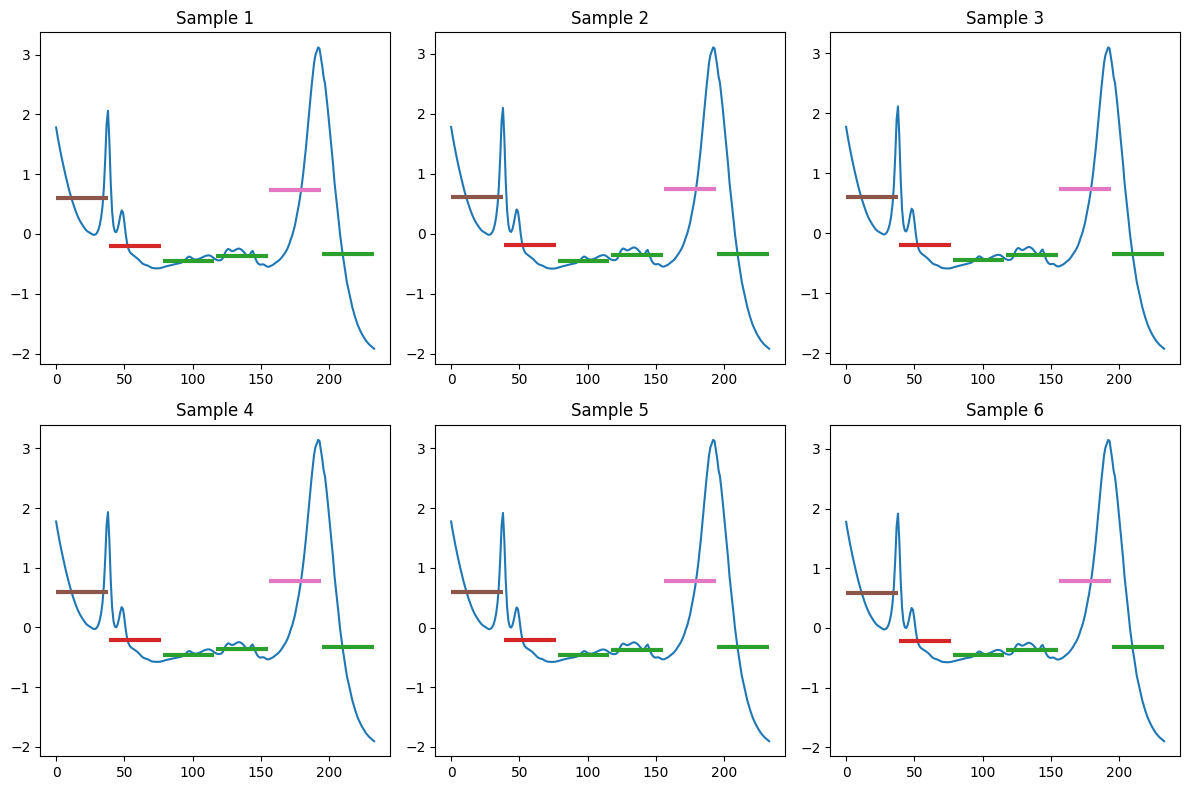

In [23]:
from aeon.datasets import load_classification

dataset, y, meta_data = load_classification("Wine", return_metadata=True)
applySAX(dataset, n_segments=6, alphabet_size=8)

dataset.shape: (111, 1, 234)
111 samples, 1 dimension, 234 time steps

dataset_scaled.shape: (111, 234)
dataset_sax.shape: (111, 1, 6)

6 segments
39 time steps per segment


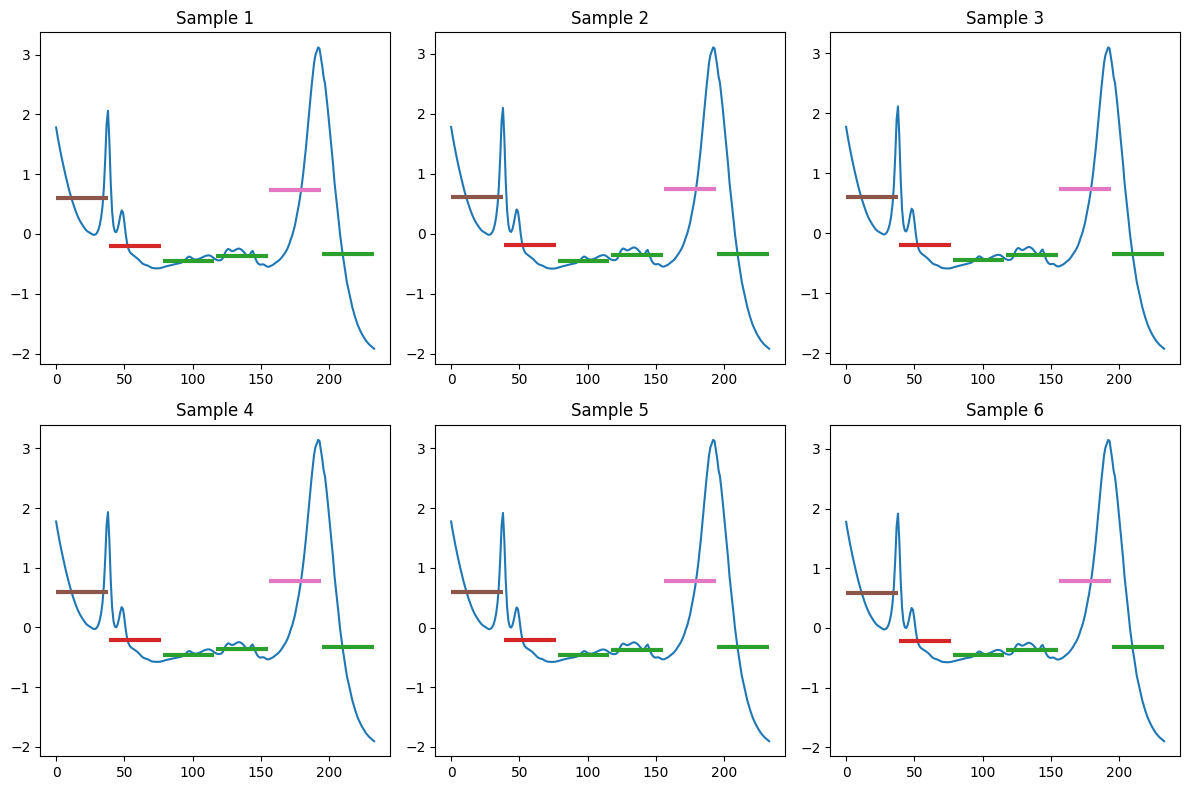

In [22]:
from aeon.datasets import load_classification

dataset, y, meta_data = load_classification("Wine", return_metadata=True)

sax_wine = SAXTransformer(n_segments=6, alphabet_size=8)
dataset, dataset_sax, dataset_scaled = sax_wine.transform(dataset)
sax_wine.drawGrid(dataset, dataset_scaled, dataset_sax) #rows=2, columns=4

## P2S Dataset 

In [3]:
from datasets import load_dataset

# Replace 'dataset_name' with the name of the dataset you want to load
dataset = load_dataset('AIML-TUDA/P2S', 'Decoy', download_mode='reuse_dataset_if_exists')

# If the dataset has specific configurations (like splits), you can specify them
# For example, to load only the 'train' split:
# dataset = load_dataset('dataset_name', split='train')

In [4]:
# You can access the data like this:
#print(dataset)

# Print the first example in the dataset
# print(dataset['train'][0])  # Use 'train', 'test', etc. as needed

X = dataset['train']

print(X.shape)
# (1154, 4)
print(X[0])


(1154, 4)
{'dowel_deep_drawing_ow': [-0.03910964388259289, -0.03832205561636692, -0.03741431603064883, -0.037202295249780394, -0.036811044248177834, -0.036316894233153776, -0.03536067678523712, -0.03337899046212013, -0.03353588211376276, -0.03280290130876047, -0.03207377712077398, -0.03133509522974834, -0.03032997140663135, -0.029221948570092887, -0.027924951499780387, -0.027465734609899435, -0.026054771712120128, -0.025125550583314046, -0.02425697335975635, -0.02351829146873071, -0.02277960957770507, -0.021912597358153783, -0.020676635444091287, -0.01977441063439577, -0.01866638779785731, -0.018081076299459875, -0.01709121126540539, -0.01599844721792943, -0.01497806460574994, -0.014239382714724302, -0.013315247848939041, -0.012441584362360519, -0.011702902471334877, -0.010338610228746733, -0.009599928337721095, -0.008751696166246737, -0.007802129985357315, -0.007270811125181031, -0.006144865266569163, -0.00528090853103039, -0.004188144483554433, -0.003245229569692248, -0.0028758886241

# Testing Playground

In [27]:
a = np.array([1,2,3,4,5])
a = np.append(a, 2*[6])
print(a)


dataset = np.array([[[1, 2, 3, 6]],
                    [[1, 2, 3, 6]],
                    [[1, 2, 3, 6]],
                    [[6, 3, 2, 1]],
                    [[1, 2, 3, 6]],
                    [[1, 2, 3, 6]],
                    [[1, 2, 3, 6]],
                    [[6, 3, 2, 1]],])

print(dataset.shape)
print(np.mean(dataset, axis=2))

remainder = 5
meansToFill = np.repeat(np.mean(dataset, axis=2), remainder, axis=1)
dataset = np.append(dataset[:,0,:], meansToFill, axis = 1)
dataset = np.expand_dims(dataset, 1)

print(dataset)

# Annotate with the corresponding alphabet label
#plt.text((start + end_excl) / 2, s_value, sample[s], color='black',
         #fontsize=12, ha='center', va='bottom', fontweight='bold')


[1 2 3 4 5 6 6]
(8, 1, 4)
[[3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]]
[[[1. 2. 3. 6. 3. 3. 3. 3. 3.]]

 [[1. 2. 3. 6. 3. 3. 3. 3. 3.]]

 [[1. 2. 3. 6. 3. 3. 3. 3. 3.]]

 [[6. 3. 2. 1. 3. 3. 3. 3. 3.]]

 [[1. 2. 3. 6. 3. 3. 3. 3. 3.]]

 [[1. 2. 3. 6. 3. 3. 3. 3. 3.]]

 [[1. 2. 3. 6. 3. 3. 3. 3. 3.]]

 [[6. 3. 2. 1. 3. 3. 3. 3. 3.]]]


### Visualization

In [ ]:
# Example time series data
n = 100  # Number of time steps
time_series = np.sin(np.linspace(0, 10, n))  # Example time series data

# Define segments as pairs of (start, end) indices
segments = [(10, 20), (20, 30), (30, 40), (40, 50), (50, 99)]  # Segment start and end points

# Define the alphabet with 4 categories (A, B, C, D) corresponding to 4 colors
alphabet = ['A', 'B', 'C', 'D']  # Example alphabet of 4 categories
segment_labels = ['A', 'B', 'C', 'A', 'D']  # Example labels for each segment

# Define colors for each category in the alphabet
colors = {'A': 'orange', 'B': 'blue', 'C': 'green', 'D': 'red'}

# Plot the time series
plt.plot(time_series, label="$Time Series")

# Mark each segment with a different color based on its label
for i, (seg_start, seg_end) in enumerate(segments):
    label = segment_labels[i] # Get the label for the current segment (e.g., 'A', 'B', etc.)
    color = colors[label]  # Assign the corresponding color
    plt.axvspan(seg_start, seg_end, color=color, alpha=0.3, label=f"Segment {label}")

# Remove duplicate labels in the legend (for unique categories)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Time Series with Segments Marked by Alphabet Categories")
plt.show()


In [ ]:
# Generate example time series data
n = 100
time_series = np.sin(np.linspace(0, 10, n)) * 10  # Example time series data

# Define segments as pairs of (start, end) indices with constant values
segments = [(5, 20), (20, 30), (30, 50), (50, 70), (70, 80), (80, 95)]  # Segment boundaries
segment_values = [4, 6, 5, 7, 3, 8]  # Horizontal segment values for the plot (y-values)

# Define an alphabet with corresponding labels and colors for each segment
alphabet = ['a', 'b', 'c', 'd']  # Alphabet labels
colors = ['red', 'green', 'blue', 'orange']  # Colors for each segment

# Assign each segment a label from the alphabet
segment_labels = ['a', 'b', 'c', 'd', 'a', 'b']  # Alphabetic labels for each segment

# Plot the time series
plt.plot(time_series, color='purple', alpha=0.4)  # The main time series

# Mark each segment with horizontal lines and annotate them
for i, (seg_start, seg_end) in enumerate(segments):
    y_value = segment_values[i]  # Constant y-value for the segment
    color = colors[alphabet.index(segment_labels[i])]  # Color for the segment
    plt.hlines(y=y_value, xmin=seg_start, xmax=seg_end, color=color, linewidth=3)  # Horizontal line
    
    # Annotate with the corresponding alphabet label
    plt.text((seg_start + seg_end) / 2, y_value, segment_labels[i], color='black', 
             fontsize=12, ha='center', va='bottom', fontweight='bold')

# Show the plot
plt.title("Time Series with Colored Horizontal Segments")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps

# Example time series data
n = 100
time_series = np.sin(np.linspace(0, 10, n)) * 10  # Example time series data

# Define segments as pairs of (start, end) indices with constant values
segments = [(5, 20), (20, 30), (30, 50), (50, 70), (70, 80), (80, 95)]  # Segment boundaries
segment_values = [4, 6, 5, 7, 3, 8]  # Horizontal segment values for the plot (y-values)

# Define an alphabet with corresponding labels
alphabet = ['a', 'b', 'c', 'd']  # Alphabet labels
segment_labels = [0,1,2,3,0,1]  # Alphabetic labels for each segment

get_color = colormaps['tab10']

# Plot the time series
plt.plot(time_series, color='purple', alpha=0.4)  # The main time series

# Mark each segment with horizontal lines and annotate them
for i, (seg_start, seg_end) in enumerate(segments):
    y_value = segment_values[i]  # Constant y-value for the segment
    color = get_color(segment_labels[i])# Get color from the colormap based on the label
    plt.hlines(y=y_value, xmin=seg_start, xmax=seg_end, color=color, linewidth=3)  # Horizontal line
    
    # Annotate with the corresponding alphabet label
    plt.text((seg_start + seg_end) / 2, y_value, segment_labels[i], color='black', 
             fontsize=12, ha='center', va='bottom', fontweight='bold')

# Show the plot
plt.title("Time Series with Colored Horizontal Segments (Auto Colors)")
plt.show()
